## Name: Muhammad Umer Farooq
## Student ID: 22402098

# Assignment 3: Class Activation Map
In this assignment we will use the [Class Activation Mapping Technique](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) to demonstrate that object specific spatial information is available in pre-trained image classification networks.

## Introduction:
The final output convolution layers of a trained image classification network contain detailed semantic information about the input image. These feature maps, although low resolution (e.g. 7 x 7) also contain spatial information about the location of the primary object in the image. In the class activation mapping technique we wish to extract this spatial information pertaining to the identified class and overlay this activation on the input image as shown in the figure below.

![](https://github.com/tonyscan6003/etivities/blob/main/cam_img.JPG?raw=true)
























## HouseKeeping
  Import Packages, set batch size and Size of Images input to network.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds

In [2]:
from tensorflow.keras.models import Model, Sequential
import seaborn as sns

In [3]:
# Global Variables
batch_size = 16
HW_trg =224

## Import Dataset

 For this notebook we will use the ImageNett dataset which contains a sub-set of the ImageNet test dataset with only 10 examples per class. This will be sufficient to demonstrate the Class Activation Mapping algorithm.
 * The dataset `train_dataset` returns a tuple containing a batch of images and a batch of numerical ground truth labels.

 * Note that if your algorithm is working sucessfully and you want to try additional examples, enable shuffling on the train dataset in the second code cell below.

In [4]:
# Load ImageNett Dataset (10 Classes)
src_train_dataset,info = tfds.load('imagenette',split ='train',with_info=True)
src_val_dataset,info = tfds.load('imagenette',split ='validation',with_info=True)
#src_train_dataset,info = tfds.load('imagenet_v2',split ='test',with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incompleteNHTBYZ/imagenette-train.tfrecord*.…

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incompleteNHTBYZ/imagenette-validation.tfrec…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0. Subsequent calls will reuse this data.


In [5]:
# Prepare Dataset
train_img_dataset = src_train_dataset.map(lambda x: x['image'])
# Function to Resize images to 224 x 224
def image_pipe(image,label):
  image = tf.image.resize_with_pad(image,HW_trg,HW_trg)
  return image,label

# Apply Image Pipeline and Batching
train_label_dataset = src_train_dataset.map(lambda x: x['label'])
train_dataset = tf.data.Dataset.zip((train_img_dataset, train_label_dataset))
train_dataset = train_dataset.map(image_pipe).batch(batch_size)
#train_dataset = train_dataset.map(image_pipe).batch(batch_size).shuffle(100)

# Prepare Dataset
val_img_dataset = src_val_dataset.map(lambda x: x['image'])
# Function to Resize images to 224 x 224
def image_pipe(image,label):
  image = tf.image.resize_with_pad(image,HW_trg,HW_trg)
  return image,label

# Apply Image Pipeline and Batching
val_label_dataset = src_val_dataset.map(lambda x: x['label'])
val_dataset = tf.data.Dataset.zip((val_img_dataset, val_label_dataset))
val_dataset = val_dataset.map(image_pipe).batch(batch_size)


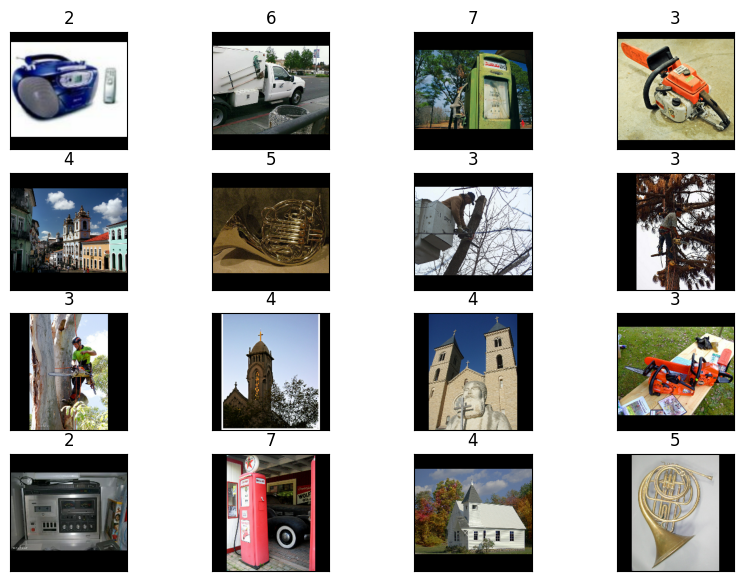

In [6]:
# Display Sample Images
def display_dataset_img(dataset):
    fig = plt.figure(figsize=(10, 7))
    i =0
    for img_batch, label_batch in dataset.take(1):
       for img in img_batch:
        label=label_batch[i]
        img = tf.cast(img,tf.uint8)
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.title.set_text(str(tf.get_static_value(label)))
        ax.imshow(img)
        i+=1

display_dataset_img(train_dataset)

# Class Activion Mapping
You can implement the class activation mapping algorithm in the code cell below.
* Try to understand the algorithm and plan out the steps required before starting to code.
* It is recommeded to use a pre-trained model: [keras pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications)
 * The keras model is easily modified to output intermediate feature maps aswell as output probabilties.  
 * Use model.summary() to print the list of layer names to identify those that you want to output.
* It is recommended to initially extract required layer weights from the model and also pass a batch of images through the model to obtain the feature vectors and output probabilities needed to produce the class activation map.
 * How to access [model weights](https://stackoverflow.com/questions/56945060/how-to-get-the-values-of-weights-and-biases-of-keras-layer) or slightly different [method](https://www.gcptutorials.com/post/how-to-get-weights-of-layers-in-tensorflow)
 * Note use of [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input) and [decode_predictions](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/decode_predictions) methods available for various pretrained models.
* You can display your final results on a 4 x 4 plot of images similar to that used in the previous code cell. (These invidual 16 images correspond to a single batch in the dataset `train_dataset` ).
* The activation map using a heat map color scheme can be overlaid on the images using matplotlib "alpha" which sets the transparancy of the image e.g. `plt.imshow(class_act_map,cmap=plt.cm.jet,alpha=0.4)`


In [17]:
# Class Activation Mapping
NUM_OF_CLASSES = 10
img_size = (HW_trg, HW_trg, 3)

# Pre-trained VGG16 model will be used (It is just personal preference, however a different trained model can also be used)
# Top classification layer are removed from the model
base_model = tf.keras.applications.vgg16.VGG16(input_shape=img_size,
                                               include_top=False,
                                               weights='imagenet')

# The following line of code will summarise VGG16 model layers
base_model.summary()

# A new model will be created from the existing VGG16 model
seq_model = Sequential()

#########################################################################################################
# The last convoulation layer in VGG16 model uses MaxPooling2D, as per the paper we need higher spatial #
# resolution, hence MaxPooling2D needs to be removed from the model. The following for loop removes the #
# the pooling layer and add the remaining layers of the model to the new sequential model               #
#########################################################################################################

for layer in base_model.layers[:-1]:
  layer.trainable = False
  seq_model.add(layer)
############################################################################################
# The paper suggests that we need to add a 3 x 3 convolution with 1024 elements before a   #
# global pooling layer, the following has been done in the following lines of code         #
############################################################################################

seq_model.add(tf.keras.layers.Conv2D(1024, (3, 3), padding = 'same', activation='relu', name = "new_conv"))

# As a new convolution layer has been added we need to complete the model so that we can train it
seq_model.add(tf.keras.layers.GlobalAvgPool2D())
seq_model.add(tf.keras.layers.Dense(NUM_OF_CLASSES, activation='softmax'))

seq_model.summary()
#############################################################################################
# Since we have added a new convolution layer in our model, hence we need to train the last #
# convolution layer in the model. The following line of code trains for the last layer.     #
#############################################################################################
seq_model.compile(loss='SparseCategoricalCrossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = seq_model.fit(train_dataset, epochs=2, validation_data=val_dataset)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
new_model = Model(seq_model.inputs, [seq_model.output, seq_model.get_layer("new_conv").output])
new_model.summary()

# Let's obtain the weights of the model's last layer
weights = seq_model.layers[-1].weights[0]
print(weights)
print(weights.shape)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [60]:
import heapq
# Definition of the function to obtain class activation map
COLS = 14
ROWS = 14
def obtain_class_activation_map(image, top_n):
    image_list = []
    preprocessed_img = tf.keras.applications.vgg16.preprocess_input(image)
    preprocessed_img = np.expand_dims(preprocessed_img, axis=0)

    predictions, feature_maps = new_model.predict(preprocessed_img)

    # As per the model the feature map will have the shape (1, 14, 14, 1024)
    feature_maps = feature_maps[0, :, :, :]
    # Prediction will have the shape (1, 10)
    predictions = predictions[0, :]
    predictions = predictions.tolist()
    # Obtain indices of top_n elements in the predictions
    res = [predictions.index(i) for i in heapq.nlargest(top_n, predictions)]
    for i in res:
      weights_to_use = weights[:, i]
      new_img = [[0]*COLS]*ROWS
      for j in range(0, 1024):
        new_img += np.multiply(feature_maps[:, :, j], weights_to_use[j])
      image_list.append(new_img)

    return image_list

1/1 [==============================] - 0s 17ms/step


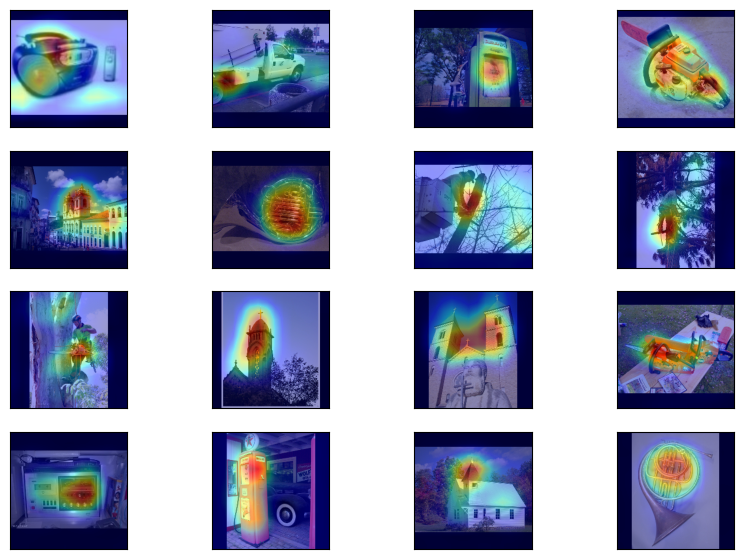

In [61]:
for batch_of_images, batch_of_labels in train_dataset.take(1):
    i = 0
    fig = plt.figure(figsize=(10, 7))
    for img in batch_of_images:
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        image_cast = tf.cast(img,tf.uint8)

        class_activation_map = obtain_class_activation_map(image_cast, 1)
        for img in class_activation_map:
          heatmap = cv2.resize(img, (224, 224))
          ax.imshow(image_cast)
          ax.imshow(heatmap,cmap=plt.cm.jet,alpha=0.4)
        i += 1

## Optional Task: Response of Top 5 predicted Classes to a Single Image.

You can modify Class your activation mapping algorithm to obtain Class activations for each of the Top 5 Predicted Classes for single image. This will produce similar result to [figure 4 in the paper](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) and shows how the different classes may respond to different regions in the image.

1/1 [==============================] - 0s 18ms/step


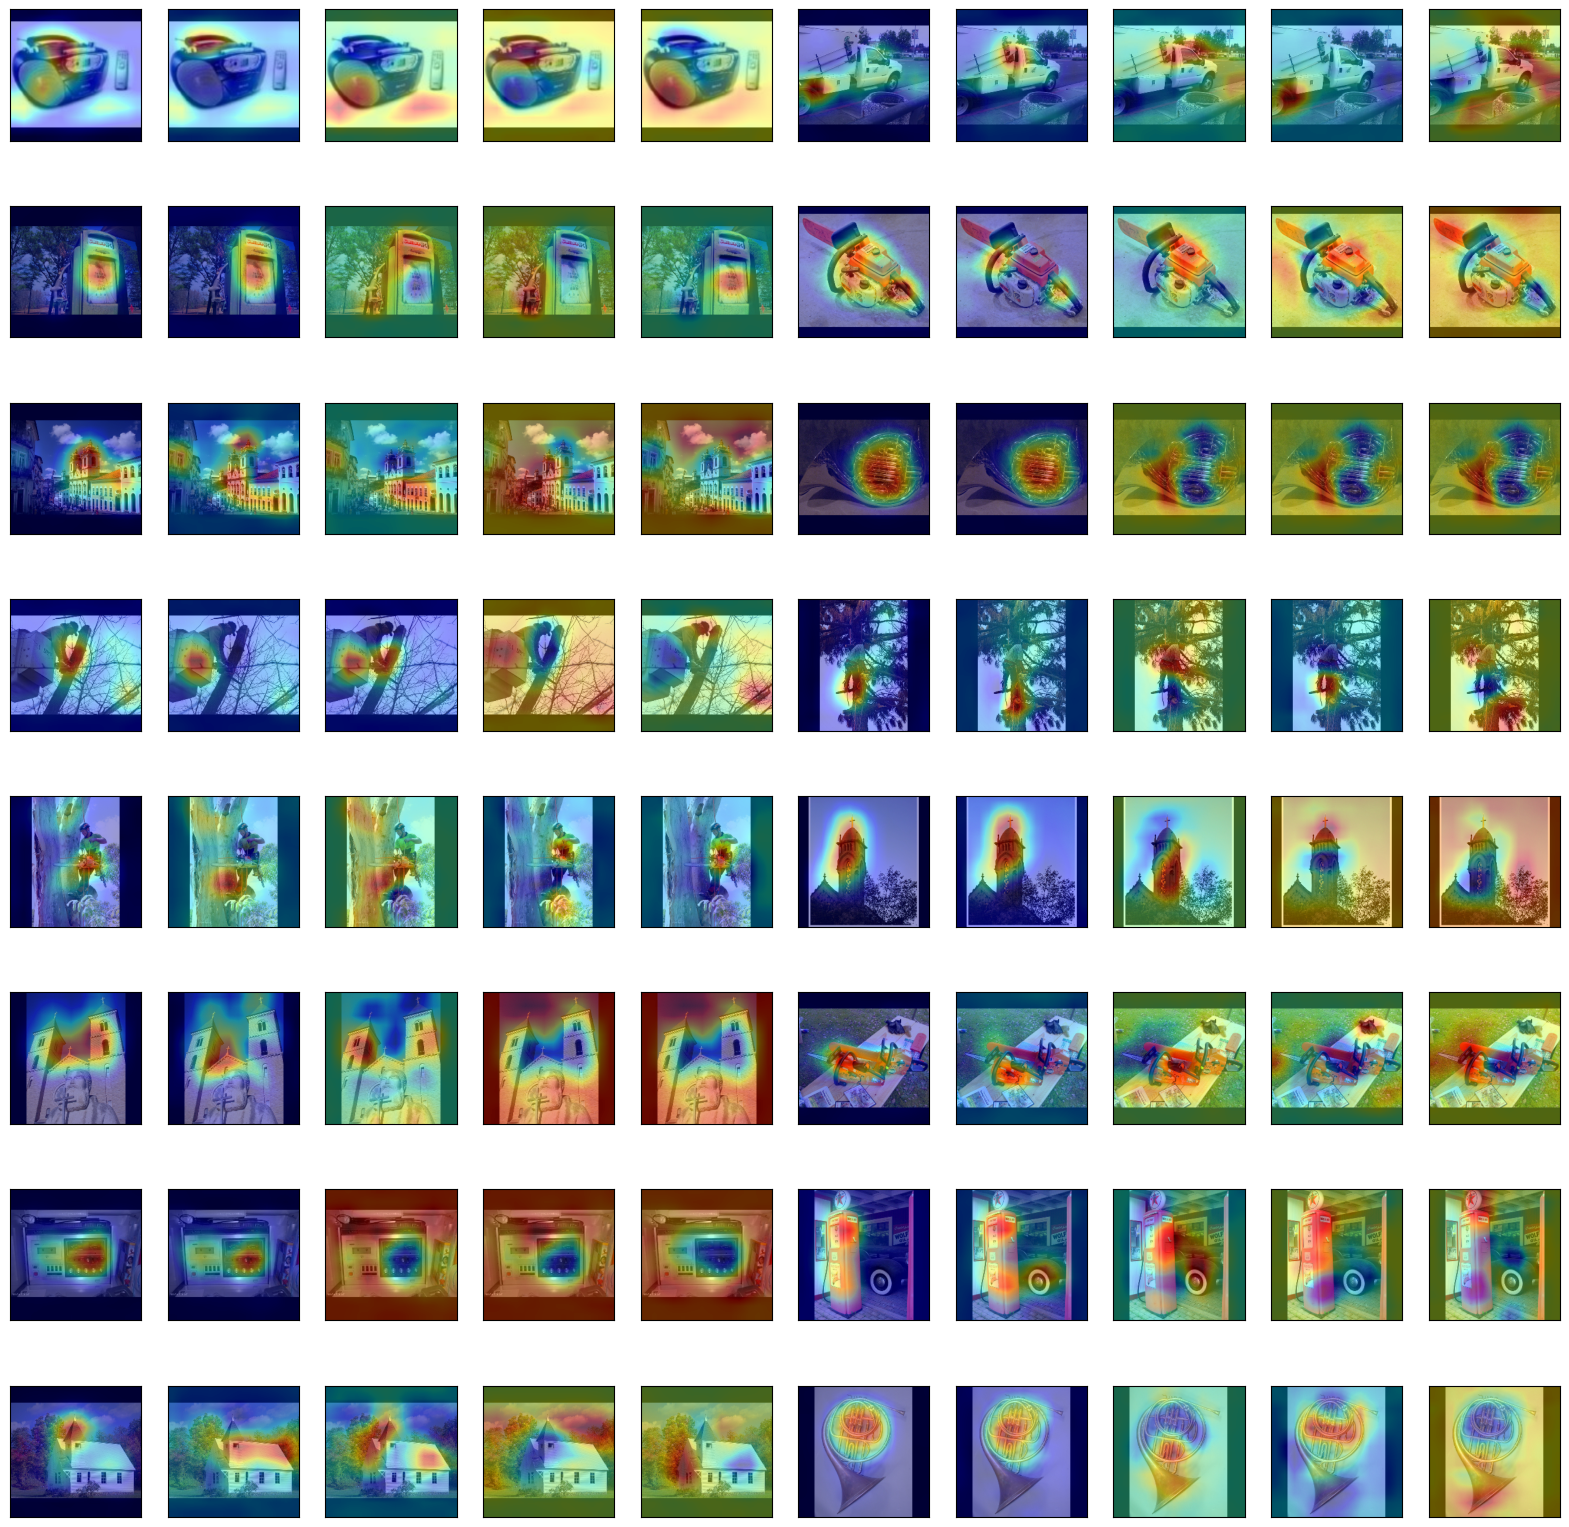

In [62]:
TOP_FIVE = 5
for batch_of_images, batch_of_labels in train_dataset.take(1):
    i = 0
    fig = plt.figure(figsize=(20, 20))
    for img in batch_of_images:
        image_cast = tf.cast(img,tf.uint8)

        class_activation_map = obtain_class_activation_map(image_cast, TOP_FIVE)
        for img in class_activation_map:
          ax = fig.add_subplot(8, 10, i + 1, xticks=[], yticks=[])
          heatmap = cv2.resize(img, (224, 224))
          ax.imshow(image_cast)
          ax.imshow(heatmap,cmap=plt.cm.jet,alpha=0.4)
          i += 1

# You may Leave a note here explaining your approach/results for the e-moderator.

I have worked out the solution using the VGG16 model. As per the paper we need to remove last pooling layer and the top of the model for this piece of work. Second, for better results we need to add another convolution layer with 1024 units and filter size od 3 x 3. Afterwards, we need to add a global average pooling layer followed by a softmax classification layer.

I have modfied the model based on the above. As we have added another convolution layer, therefore it was essential to train the model to find the appropriate kernel weights for the newly added convolution layer. Hence, I fixed the existing layers of the VGG16 model, and only trained the model for the newly added layers. The result of the model training has been shown.

As the aim of training the model was to find the weights for the newly added convoulation layer, and once that has been found we need output feature maps produced by the last convoulation layer. Moreover, we also need predictions from the model. Therefore, I amended the model so that it outputs feature map which is the output of the last convolution layer, and the predictions itself.

For each image in a batch we produce a class activation map for that image. The process starts by obtaining a prediction on the image by the designed model, and then we obtain summation of all output feature maps by multiplying them with their respective weights using the weights of the predicted class.